In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
import warnings
import json
from helper_functions import find_dips_robust, find_index
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [2]:
def lin_func(x, a):
    return a * x

def xps_ws_func(x, a, p):
    return a * x ** p

def xps_res_func(x, a, b, c):
    return a * x ** 2 + b * x + c

def get_fsr(dips: list):  # get the 
    dif = [abs(d - 1310) for d in dips]
    min_id = dif.index(min(dif))
    return dips[min_id] - dips[min_id-1]

# Find P_pi
def find_pi_values(wavel: list, trans: list[list], volts: list, currs: list, wl_range: list, v_u_id: int, thres, fit_funcs: list) -> float:
    wl_l, wl_u = wl_range[0], wl_range[1]
    l_id, u_id = find_index(wl_l, wavel), find_index(wl_u, wavel)
    res = np.divide(volts[1:], np.divide(currs[1:], 1000))
    elec_pwrs = np.multiply(volts, currs)
    
    dips_0V = find_dips_robust(wavel[l_id:u_id], trans[0][l_id:u_id], thres)
    FSR = get_fsr(dips_0V)
    print(dips_0V)
    print(FSR)
    wavel_ref = dips_0V[0]
    
    dips = []
    for i in range(v_u_id):
        dips.append(find_dips_robust(wavel[l_id:u_id], trans[i][l_id:u_id], thres))
    
    dip = []
    for i in range(v_u_id):
        if i == 0:
            dip.append(dips[0][-1])
            continue
    
        dips[i].reverse()
        # print(dip)
        for d in dips[i]:  # the spectrum moves to the left side as voltages increases
            if d < dip[i-1]:
                dip.append(d)
                break

    # for i in range(v_u_id):
    #     if i == 0:
    #         dip.append(dips[0][0])
    #         continue
    #     for d in dips[i]:
    #         if d > dip[i-1]:
    #             dip.append(d)
    #             break

    ws_func, res_func = fit_funcs[0], fit_funcs[1]
    wavel_shift = np.array([abs(w - dip[0]) for w in dip])
    p_opt, p_cov = curve_fit(ws_func, wavel_shift, elec_pwrs[:v_u_id])
    P_pi = ws_func(FSR, *p_opt)/2

    # fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    # ax = axes[0]
    # ax.plot(wavel_shift, elec_pwrs[:v_u_id], 'o')
    # ax.plot(wavel_shift, ws_func(wavel_shift, *p_opt))
    # ax.plot(FSR, 2*P_pi, marker='*', markersize=10, color='r', label='$P_{\pi}$' + f' = {P_pi:.2f} mW\n'+f'FSR = {FSR:.2f} nm')
    # ax.set_ylabel('Electrical power (mW)')
    # ax.set_xlabel('Wavelength shift (nm)')
    # # ax.set_title(title)
    # ax.legend(prop={'size':12})
    # ax.text(3, 0, '$y=ax^p$', fontsize=12)

    p_opt, p_cov = curve_fit(res_func, elec_pwrs[1:], res)
    R_pi = res_func(P_pi, *p_opt)
    I_pi = (1000*P_pi/R_pi)**0.5
    
    return P_pi, I_pi
    

In [23]:
# MacBook
root_path = Path('/Users/jiahaozhan/Google Drive/Other Computers/CM300/Dione_wafer3_BO')
data_path = root_path / 'therm_phase_si_crossing_test_cells_dev43'

no = 0
P_pi_all = {}
I_pi_all = {}
FSR_est = 3.4269124
v_u_id = 15
thres = -30

wl_l, wl_u = 1305, 1312  # 1309, 1315  # find the pivot dip in this wl range

data_dir_gen = sorted(data_path.glob(f'reticle*/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    # print(df.columns)
    ret = int(df['reticle'][no])
    # print(ret)

    # if ret == 3:
    #     device_no = df['device_no'][no]
    #     # IK_min_width, CA_offset_x, undercut_index = df['IK_min_width'][no], df['CA_offset_x'][no], df['index'][no]
    #     length, n_seg = df['length'][no], df['n_seg'][no]
        
    wavel = df['wavelength'][no]
    trans = df['transmission_ch1'][no]
    volts = df['smu_voltage'][no]
    currs = df['smu_current'][no]
    # currs = np.multiply(df['smu_current'][no], 1000)
    
    # currs = [cr - currs[0] for cr in currs]  # for uncalibrated smu
    elec_pwrs = np.multiply(volts, currs)
    
    l_id, u_id = find_index(wl_l, wavel), find_index(wl_u, wavel)
    dips_0V = find_dips_robust(wavel[l_id:u_id], trans[0][l_id:u_id], thres)
    wl_range = [dips_0V[-1] - 1.5 * FSR_est, dips_0V[-1] + 0.5 * FSR_est]
    # wl_range = [1305, 1312]
    
    P_pi_all[ret], I_pi_all[ret] = find_pi_values(wavel, trans, volts, currs, wl_range, v_u_id, thres, [xps_ws_func, xps_res_func])

# res = np.divide(volts[1:], np.divide(currs[1:], 1000))

# print(currs)
# print(volts)
print(P_pi_all)
print(I_pi_all)

[1302.581759434624, 1305.9621109069185, 1309.3855642799967, 1312.8060377705779, 1316.253321582641, 1319.71997773778]
3.423453373078246
[1302.5784374425364, 1305.9564315515686, 1309.386003318234, 1312.801948205336, 1316.2542704650948, 1319.714576698565]
3.4295717666655037
[1303.0110600765183, 1306.4092870378095, 1309.816136093917, 1313.2573079820866, 1316.6955007368797]
3.4068490561076032
[1301.1286265927854, 1304.5029781983433, 1307.905600807897, 1311.3185696120345, 1314.7466007750527, 1318.185108253588]
3.412968804137563
[1301.3634307203588, 1304.733303085891, 1308.1386376339797, 1311.5514471328404]
3.4128094988607245
[1302.270675805098, 1305.644746557781, 1309.0531079844823, 1312.475380744991, 1315.9058190861058, 1319.359707387639]
3.4083614267012763
[1302.9249735506046, 1306.308091389168, 1309.711528756539]
3.403437367370998
[1305.3940376804635, 1308.8152839409654, 1312.2335319463896, 1315.680707819141, 1319.1428361186418]
3.4212462605019027
[1303.2649311454707, 1306.6597890123476, 

In [24]:
# plot tranmission spectra at different voltages
def plot_spectra(wavel: list, trans: list, ret: int, wl_range: list):
    # title = f"xps: IK_min_width {df['IK_min_width'][no]} um, CA_offset_x {df['CA_offset_x'][no]}, undercut_index {df['index'][no]}"
    title = f'Reticle {ret}'
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    for i in [0,2,4,6,8,10,11,12]:
        ax.plot(wavel, trans[i], label=f'{volts[i]:.2} V')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Transmission (dB)')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(wl_range)
    # ax.text(xlim[1]-2, -61, '$P_{\pi}$ = ' + f'{P_pi:.2f} mW', fontsize=12)

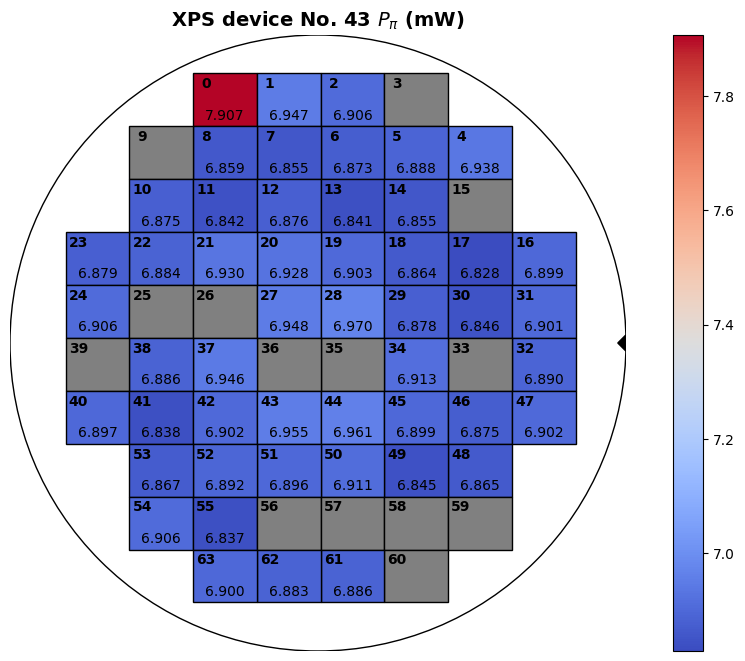

In [27]:
# get wafer plot
device_no = 43
# title = f'HPS ' + '$P_{\pi}$ (mW)'
title = f'XPS device No. {device_no} ' + '$P_{\pi}$ (mW)'
draw_wafer_plot(data=P_pi_all, title=title)

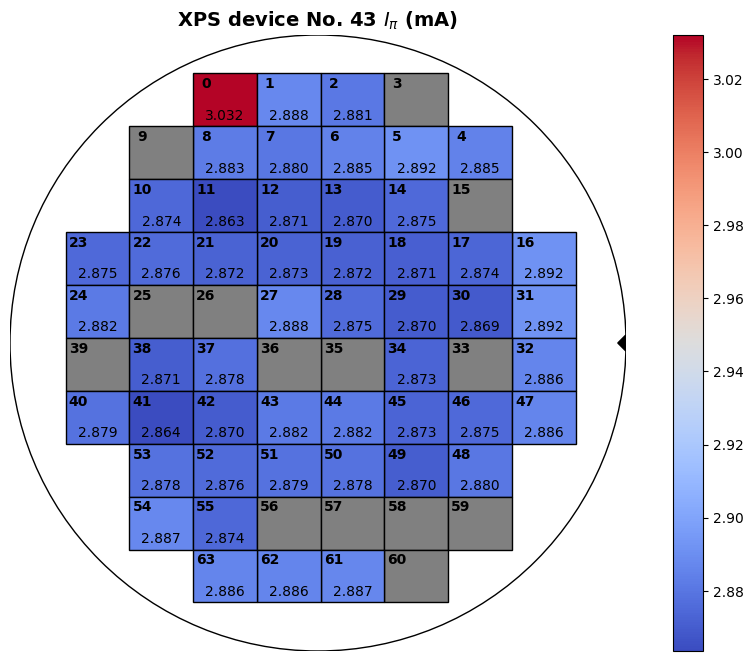

In [28]:
# get wafer plot
# title = f'HPS ' + '$I_{\pi}$ (mA)'
title = f'XPS device No. {device_no} ' + '$I_{\pi}$ (mA)'
draw_wafer_plot(data=I_pi_all, title=title)